In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-10, 6, 2)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

# cosine similarity

In [3]:
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })
project_method = '-lda'

for instrument in instrument_map:
    for embedding in ['vggish', 'openl3', 'yamnet']:
        for train_set in ['A', 'B']:

            embedding_sim = pd.DataFrame({'instrument': [],
                'embedding': [],
                'train set': [],
                'cosine similarity': [],
                })
            
            embedding_sim['instrument'] = [instrument]
            embedding_sim['embedding'] = [embedding]
            embedding_sim['train set'] = [train_set]

            file = open('models/LDAcoef_' + train_set + '_' + embedding + project_method + '.pickle', 'rb')
            dataset_sep = pickle.load(file)
            file.close()

            # load the trained instrument classification model
            file = open('models/models_' + train_set + '_' + embedding + '.pickle', 'rb')
            inst_sep = pickle.load(file)
            file.close()

            embedding_sim['cosine similarity'] = [cosine_similarity(inst_sep[instrument].best_estimator_.coef_, dataset_sep[instrument])[0][0]]
            
            cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv('results/cosine_similarity.csv', index=False)

In [4]:
cosine_sim

,instrument,embedding,train set,cosine similarity
0,cello,vggish,A,-0.307924
0,cello,vggish,B,0.162920
0,cello,openl3,A,-0.214602
0,cello,openl3,B,0.138856
0,cello,yamnet,A,-0.008055
...,...,...,...,...
0,voice,vggish,B,0.235915
0,voice,openl3,A,0.060146
0,voice,openl3,B,0.336196
0,voice,yamnet,A,0.000471


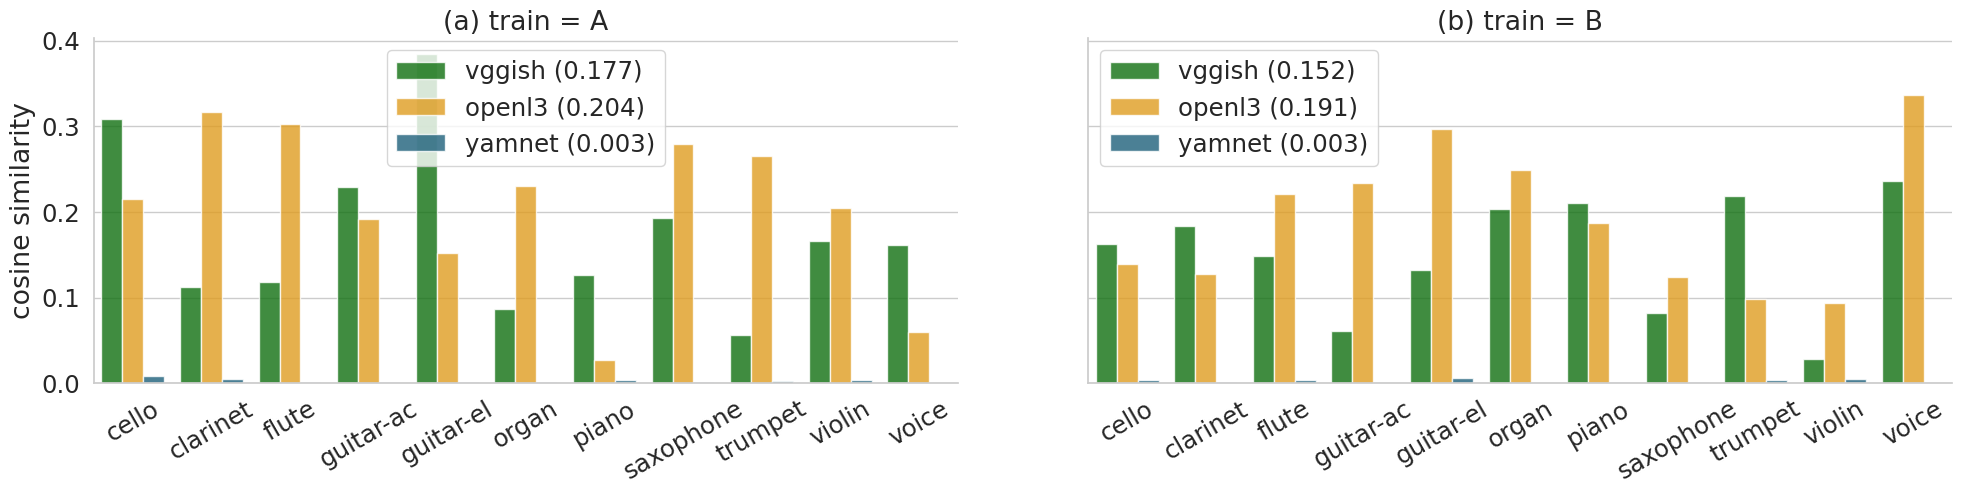

In [5]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('results/cosine_similarity.csv')
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = A")
handles, labels = a0.get_legend_handles_labels()
df_A = df[df['train set']=='A']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_A[df_A['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = B")
handles, labels = a1.get_legend_handles_labels()
df_B = df[df['train set']=='B']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_B[df_B['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
plt.savefig('results/cosine_similarity.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')